# Exercises

## Exercise 1
---
Determine the effect of stimulus sequence duration on RF estimates. To do this, repeat the above steps for different durations (5 s, 10 s, 20 s, 40 s, 80 s, 160 s, 320 s, 640 s). Compute the Pearson correlation between true and estimated RFs for each duration to quantify the accuracy of the estimator. The Pearson correlation $\mathrm{cc}$ is defined as
$$
\mathrm{cc} = \frac{\mathbf{k}_\mathrm{true}^T \hat{\mathbf{k}}}{\lVert \mathbf{k}_\mathrm{true} \rVert \lVert \hat{\mathbf{k}} \rVert}
$$
where $\lVert \cdot \rVert$ is the L2-norm (vector length).
As the response generation process is stochastic, compute the average correlation across 10 realizations for the same duration and plot the average correlation as a function of duration. How is the recording duration related to the ability to recover the true RF? 

In [19]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(context='notebook',style='white',font_scale=1.5,
              rc = {'axes.spines.top':False,'axes.spines.right':False})

def get_correlation(k_true, k_hat):
    """ Compute the correlation between the true and estimated filter """
    return np.dot(k_true, k_hat)/(np.linalg.norm(k_true)*np.linalg.norm(k_hat))

# parameters
dt = .1
std_dev = 1
vf_size = (15,15)

# durations to test
durations = 10*2.**np.arange(-1,7)
correlations_per_duration = dict()

for duration in durations:
    
    correlations = []

    for i in range(10):
        
        # initiate parameters
        n_bins = round(duration / float(dt))

        S = std_dev * np.random.randn(n_bins,vf_size[0],vf_size[1])

        # Gabor filter
        size = vf_size # size in pixel of our receptive field
        mu = (8, 8) # center of the gabor pathc
        sigma = (4,4) #size of the gabor patch
        angle = 45 # orientation of the gabor patch
        frequency = .085 # spatial frequency of the gabor patch
        phase = 0 # pahse of the gabor pathc


        xx, yy = np.meshgrid(1. + np.arange(size[0]),
                            1. + np.arange(size[1]))

        # Gaussian envelope
        G = np.exp(- np.power(xx - mu[0], 2) / (2. * sigma[0])
                    - np.power(yy - mu[1], 2) / (2. * sigma[1]))

        # spatial modulation
        phi = np.deg2rad(angle)
        xxr = xx * np.cos(phi)
        yyr = yy * np.sin(phi)
        xyr = (xxr + yyr) * 2. * np.pi * 2. * frequency
        Sn = np.cos(xyr + phase)

        K = G * Sn
        K /= np.amax(np.abs(K))


        # generate the spike train
        noise_variance = 1
        offset = 2.

        # flatten the matrices in to 1d array for convenience
        K_flat = K.ravel()
        K_flat = np.hstack((K.flat, offset))

        S_flat = S.reshape(S.shape[0],S.shape[1]*S.shape[2])
        S_flat = np.hstack((S_flat, np.ones((n_bins, 1))))

        # 1. linear stage
        ks = np.dot(K_flat, S_flat.T)

        # 2. nonlinear stage (for a linear model: f -> identity function)
        rate = ks

        # add Gaussian noise centered around the "true" rate for each bin
        rate = rate + np.sqrt(noise_variance) * np.random.randn(n_bins)

        # fit the model
        K_hat = np.linalg.inv(S_flat.T @ S_flat) @ (S_flat.T @ rate)
        K_hat_flat = K_hat.copy()
        K_hat = K_hat[:-1].reshape(vf_size)
        
        # compute correlation between true and estimated filter
        correlations.append(get_correlation(K_flat, K_hat_flat))

    # compute mean of correlation per duration
    correlations_per_duration[duration] = (np.mean(correlations), np.min(correlations), np.max(correlations))

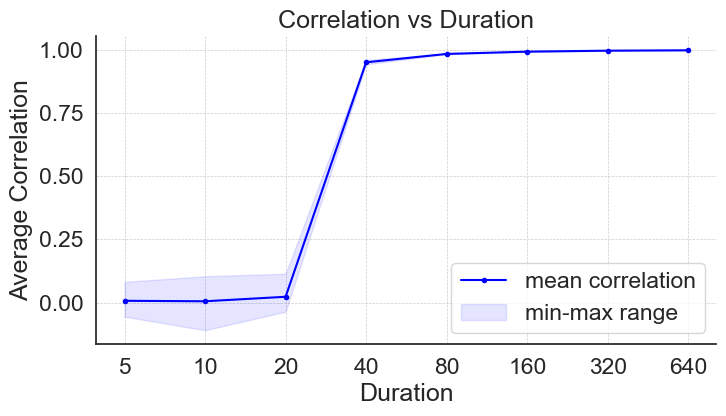

In [20]:
fig, ax = plt.subplots(figsize=(8, 4))

# Extracting the data for plotting
durations = list(correlations_per_duration.keys())
cor_mean = [x[0] for x in list(correlations_per_duration.values())]
cor_min = [x[1] for x in list(correlations_per_duration.values())]
cor_max = [x[2] for x in list(correlations_per_duration.values())]

# Plotting the mean correlation and the min-max range
ax.plot(durations, cor_mean, color = "blue", marker = ".", label = "mean correlation")
ax.fill_between(durations, cor_min, cor_max, color = "blue", alpha=0.1, label = "min-max range")

# Setting x-axis to log scale with base 2 and labeling x-axis according to the presentation durations
ax.set_xscale('log', base=2)
ax.set_xticks(durations)
ax.get_xaxis().set_major_formatter(plt.ScalarFormatter())

# Adding labels and title
ax.set_xlabel('Duration')
ax.set_ylabel('Average Correlation')
ax.set_title('Correlation vs Duration')
ax.legend()

ax.grid(True, linestyle='--', linewidth=0.5)

plt.show()


From this plot, we can observe that the filter accuracy grows with the presentation duration. However, this relationhip does not seem to follow a linear trend but does so rather in a sigmoidal fashion. The correlation only grows slowly between 5 and 20s of presentation, then grows quickly to above .90 for 40s of presentation and after that grows slowly again. This is likely due to the fact that the power of the General Linear Model grows like the CDF of the standard normal distribution of the square root of the sample size $n$.